In [15]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

%matplotlib inline

---
### Step0: Load the data

In [2]:
training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
test_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
     train = pickle.load(f)
with open(validation_file, mode='rb') as f:
     valid = pickle.load(f)
with open(test_file, mode='rb') as f:
     test = pickle.load(f)
        
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#### Observe the test data randomly
You can see the test data by pressing keys [ctl]+[enter].

---
### Step1: Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:
 - 'features' is a 4D array containing raw pixel data of the traffic sign images.
 - 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
 - 'sizes' is a list containing tuples, (width,height) representing the original width and height the image.
 - 'coords' is a list containing tuples, (x1,y1,x2,y2) representing coordinates of a bounding box around the sign in the image.**These coordinates assume the original image. The pickled data contains resized versions(32x32) of these images.**

In [8]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = pd.Series(y_train).nunique()

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Text(0.5, 1.0, '1690')

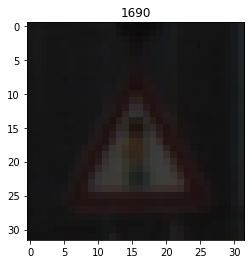

In [69]:
rand_idx = random.randint(0, X_train.shape[0])
plt.imshow(X_train[rand_idx])
plt.title(rand_idx)

In [9]:
path = 'signnames.csv'
sign_names = pd.read_csv(path)

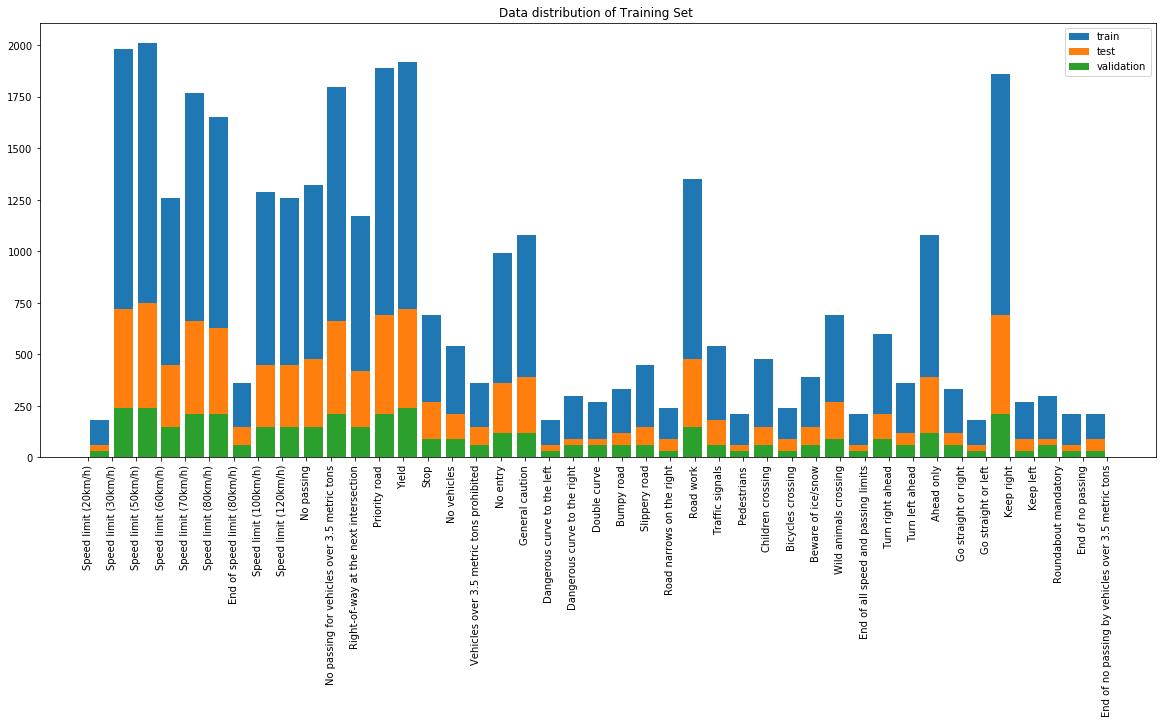

In [11]:
plt.figure(figsize=(20, 8))
plt.hist(y_train, bins=n_classes, rwidth=0.8, label='train')
plt.hist(y_test, bins=n_classes, rwidth=0.8, label='test')
plt.hist(y_valid, bins=n_classes, rwidth=0.8, label='validation')
plt.title('Data distribution of Training Set ')
plt.xticks(sign_names['ClassId'], sign_names['SignName'], rotation=90)
plt.legend()
plt.show()

---
### Step2: Design and Test a Model Architecture

In [19]:
mu = 0
sigma = 0.1
in_channel = 3
out = n_classes

weights = {
    'cw1': tf.Variable(tf.truncated_normal((5,5,in_channel,6), mu, sigma)),
    'cw2': tf.Variable(tf.truncated_normal((5,5,6,16), mu, sigma)),
    'fw1': tf.Variable(tf.truncated_normal((400,120), mu, sigma)),
    'fw2': tf.Variable(tf.truncated_normal((120,84), mu, sigma)),
    'fw3': tf.Variable(tf.truncated_normal((84,out), mu, sigma))
}
biases = {
    'cb1': tf.Variable(tf.zeros(6)),
    'cb2': tf.Variable(tf.zeros(16)),
    'fb1': tf.Variable(tf.zeros(120)),
    'fb2': tf.Variable(tf.zeros(84)),
    'fb3': tf.Variable(tf.zeros(out))
}

In [20]:
x = tf.placeholder(tf.float32, shape=(None,32,32,3))
y = tf.placeholder(tf.int32, (None))
one_hot = tf.one_hot(y, n_classes)

# 32x32x3 => 28x28x6 => 14x14x6
conv1 = tf.nn.conv2d(x, weights['cw1'], strides=[1,1,1,1], padding='VALID') + biases['cb1']
conv1 = tf.nn,relu(conv1)
conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

# 14x14x6 => 10x10x16 => 5x5x16
conv2 = tf.nn.conv2d(conv1, weights['cw2'], [1,1,1,1], 'VALID') + biases['cb2']
conv2 = tf.relu(conv2)
conv2 = tf.nn.max_pool(conv2, [1,2,2,1], [1,2,2,1], 'VALID')

# 5x5x16 => 1x400
fc0 = flatten(conv2)

# 1x400 => 1x120
fc1 = tf.matmul(fc0, weights['fw1']) + biases['fb1']
fc1 = tf.nn.relu(fc1)

# 1x120 => 1x84
fc2 = tf.matmul(fc1, weights['fw2']) + biases['fb2']
fc2 = tf.nn.relu(fc2)

# 
fc3 = tf.matmul(fc2, weights['fw3']) + biases['fb3']

NameError: name 'relu' is not defined